#Programming assignment #5

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, precision_score, recall_score, roc_curve, auc, f1_score

## 1 Supervised learning

> Here, you are going to use the features you generated in Assignment #3 to predict the
clients response to a promotion campaign. This is a typical classification problem in the retail industry, but the formulation of the problem is similar to industries such as fraud detection, marketing and manufacturing.
>
> The clients responses are stored in the Retail_Data_Response.csv file from Kaggle. The responses are **binary: 0** for clients who responded negatively to the promotional campaign and **1** for clients who responded positively to the campaign.
>
> You will explore solving the classi cation problem with two different sets of features (i.e. annual and monthly) and three different algorithms as shown in the image below.

### 1.1 Import the monthly and annual data and join

>In Assignment #3, you created five different feature families that capture annual and monthly aggregations. Here, you will model the retail problem with two approaches: using annual and monthly features. Therefore, you need to create the joined tables based on the following
logic:

|Table | annual features outputs | monthly features outputs|
| ----------- | ----------- |----------- |
|#1| annual_features.xlsx| mth_rolling_features.xlsx|
|#2| annual_day_of_week_counts_pivot.xlsx|mth_day_counts.xlsx|
|#3| |days_since_last_txn.xlsx|
|#4| Retail_Data_Response.csv| Retail_Data_Response.csv|
> In both the annual and monthly features approach, you need to join at the end with table #4, the clients responses. This is simply a table that contains the binary response of the
client to our marketing effort as described above and that is the output or label or target
that makes this a supervised learning problem.

In [ ]:
#read kaggle data
kaggle = pd.read_csv('Retail_Data_Response.csv')

In [ ]:
#create annual features
annual_features = pd.read_excel('annual_features.xlsx')

annual_pivot = pd.read_excel('annual_day_of_week_counts_pivot.xlsx')

annual_features_outputs = pd.merge(annual_features, annual_pivot, on = 'customer_id').merge(kaggle, on = 'customer_id')
annual_features_outputs.head()

,customer_id,ann_txn_amt_ave_2011,ann_txn_amt_ave_2012,ann_txn_amt_ave_2013,ann_txn_amt_ave_2014,ann_txn_amt_ave_2015,ann_txn_amt_cnt_2011,ann_txn_amt_cnt_2012,ann_txn_amt_cnt_2013,ann_txn_amt_cnt_2014,ann_txn_amt_cnt_2015,ann_txn_amt_max_2011,ann_txn_amt_max_2012,ann_txn_amt_max_2013,ann_txn_amt_max_2014,ann_txn_amt_max_2015,ann_txn_amt_min_2011,ann_txn_amt_min_2012,ann_txn_amt_min_2013,ann_txn_amt_min_2014,ann_txn_amt_min_2015,ann_txn_amt_sem_2011,ann_txn_amt_sem_2012,ann_txn_amt_sem_2013,ann_txn_amt_sem_2014,ann_txn_amt_sem_2015,ann_txn_amt_std_2011,ann_txn_amt_std_2012,ann_txn_amt_std_2013,ann_txn_amt_std_2014,ann_txn_amt_std_2015,ann_txn_amt_sum_2011,ann_txn_amt_sum_2012,ann_txn_amt_sum_2013,ann_txn_amt_sum_2014,ann_txn_amt_sum_2015,ann_txn_amt_var_2011,ann_txn_amt_var_2012,ann_txn_amt_var_2013,ann_txn_amt_var_2014,ann_txn_amt_var_2015,cnt_2011_Friday,cnt_2011_Monday,cnt_2011_Saturday,cnt_2011_Sunday,cnt_2011_Thursday,cnt_2011_Tuesday,cnt_2011_Wednesday,cnt_2012_Friday,cnt_2012_Monday,cnt_2012_Saturday,cnt_2012_Sunday,cnt_2012_Thursday,cnt_2012_Tuesday,cnt_2012_Wednesday,cnt_2013_Friday,cnt_2013_Monday,cnt_2013_Saturday,cnt_2013_Sunday,cnt_2013_Thursday,cnt_2013_Tuesday,cnt_2013_Wednesday,cnt_2014_Friday,cnt_2014_Monday,cnt_2014_Saturday,cnt_2014_Sunday,cnt_2014_Thursday,cnt_2014_Tuesday,cnt_2014_Wednesday,cnt_2015_Friday,cnt_2015_Monday,cnt_2015_Saturday,cnt_2015_Sunday,cnt_2015_Thursday,cnt_2015_Tuesday,cnt_2015_Wednesday,response
0,CS1112,70.666667,67.400000,70.666667,70.666667,39.000000,3,5,3,3,1,96,81,105,90,39,56,52,36,59,39,12.719189,5.688585,19.919282,9.735388,0.000000,22.030282,12.720063,34.501208,16.862186,0.000000,212,337,212,212,39,485.333333,161.800000,1190.333333,284.333333,0.000000,1,0,0,1,0,0,1,0,0,1,3,0,1,0,1,1,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0
1,CS1113,81.333333,74.800000,85.200000,56.500000,73.333333,3,5,5,4,3,94,95,97,97,98,57,51,65,36,44,12.170091,7.618399,5.851496,13.979151,15.762121,21.079216,17.035258,13.084342,27.958302,27.300794,244,374,426,226,220,444.333333,290.200000,171.200000,781.666667,745.333333,1,1,0,1,0,0,0,2,1,0,0,0,1,1,0,1,1,0,0,2,1,0,0,1,0,0,3,0,0,2,0,0,0,0,1,0
2,CS1114,85.200000,75.000000,70.400000,70.833333,79.000000,5,2,5,6,1,97,97,105,95,79,76,53,43,37,79,4.352011,22.000000,11.129241,11.001263,0.000000,9.731393,31.112698,24.885739,26.947480,0.000000,426,150,352,425,79,94.700000,968.000000,619.300000,726.166667,0.000000,0,1,0,1,1,0,2,0,0,1,1,0,0,0,0,1,0,1,2,0,1,1,1,1,1,0,1,1,0,0,0,0,1,0,0,1
3,CS1115,87.000000,67.571429,79.571429,78.250000,55.000000,3,7,7,4,1,102,104,94,98,55,72,41,66,50,55,8.660254,8.257341,3.981249,11.316470,0.000000,15.000000,21.846870,10.533394,22.632941,0.000000,261,473,557,313,55,225.000000,477.285714,110.952381,512.250000,0.000000,0,0,1,1,0,0,1,1,1,0,2,1,1,1,0,1,2,0,2,0,2,0,0,0,0,2,0,2,0,0,0,0,1,0,0,1
4,CS1116,58.750000,76.666667,59.000000,66.600000,0.000000,4,3,1,5,0,87,105,59,96,0,41,45,59,40,0,10.601690,17.400511,0.000000,11.285389,0.000000,21.203380,30.138569,0.000000,25.234896,0.000000,235,230,59,333,0,449.583333,908.333333,0.000000,636.800000,0.000000,1,1,0,0,1,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,3,1,0,1,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
#create monthly features
mth_rolling_features = pd.read_excel('mth_rolling_features.xlsx')
mth_rolling_features = mth_rolling_features.drop('Unnamed: 0', axis = 1)
mth_rolling_features = mth_rolling_features.fillna(0)

mth_day_counts = pd.read_excel('mth_day_counts.xlsx')
mth_day_counts = mth_day_counts.drop('Unnamed: 0', axis = 1)

day_since_last_txn = pd.read_excel('days_since_last_txn.xlsx')
day_since_last_txn = day_since_last_txn.drop('Unnamed: 0', axis = 1)

mth_features_outputs = pd.merge(mth_rolling_features, mth_day_counts, on = ['CLNT_NO', 'ME_DT']).merge(day_since_last_txn, on = ['CLNT_NO', 'ME_DT']).merge(kaggle.rename(columns={'customer_id': 'CLNT_NO'}), on = 'CLNT_NO')
mth_features_outputs.head() 

,CLNT_NO,ME_DT,mth_txn_amt_sum,mth_txn_cnt,amt_sum_3M,amt_mean_3M,amt_max_3M,txn_cnt_sum_3M,txn_cnt_mean_3M,txn_cnt_max_3M,amt_sum_6M,amt_mean_6M,amt_max_6M,txn_cnt_sum_6M,txn_cnt_mean_6M,txn_cnt_max_6M,amt_sum_12M,amt_mean_12M,amt_max_12M,txn_cnt_sum_12M,txn_cnt_mean_12M,txn_cnt_max_12M,cnt_Friday,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thursday,cnt_Tuesday,cnt_Wednesday,days_since_last_txn,response
0,CS1112,2011-05-31,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,-5,0
1,CS1112,2011-06-30,56,1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,15,0
2,CS1112,2011-07-31,0,0,56.0,18.666667,56.0,1.0,0.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,46,0
3,CS1112,2011-08-31,96,1,152.0,50.666667,96.0,2.0,0.666667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,12,0
4,CS1112,2011-09-30,0,0,96.0,32.000000,96.0,1.0,0.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,42,0


### 1.2 Steps for each method (10 points)

> 1. Separate the inputs X and the output y in two data frames.
> 2. Split the data in train and test set. Use a test size value of 2/3 and set the random state
equal to 1147 for consistency (i.e. the course code value). Use the following names for
consistency.

|Annual|Monthly|
| ---------------- | ----------- |
|X_train_annual  y_train_annual| X_train_monthly  y_train_monthly|
|X_test_annual  y_test_annual|X_test_monthly  y_test_monthly|
> 3. Pre-process (if necessary for the method).
> 4. Fit the training dataset and optimize the hyperparameters of the method.
> 5. Plot coeffcient values or feature importance.
> 6. Plot probability distribution for test set.
> 7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.
> 8. Plot decision boundary for top 2 features.

#### Part 1: Annual Features

In [ ]:
#1.Separate the inputs X and the output y in two data frames.
#drop customer_id and response for X_annual
X_annual = annual_features_outputs.drop(['customer_id', 'response'], axis = 1)
y_annual = annual_features_outputs['response']

In [ ]:
#2.Split the data in train and test set.
X_train_annual, X_test_annual, y_train_annual, y_test_annual = train_test_split(X_annual, y_annual, test_size=2/3, random_state=1147)

In [ ]:
#3.Pre-processing
scaler_annual = StandardScaler()
X_train_annual = scaler_annual.fit_transform(X_train_annual)
X_test_annual = scaler_annual.transform(X_test_annual)



*   Logistic Regression with L1 regularization



In [ ]:
# 4. Fit the training dataset and optimize the hyperparameters of the method
lr = LogisticRegression(penalty ='l1', solver = 'liblinear', random_state=1147)

# Gridsearch best hyperparameters using mereic 'roc_auc'
grid = GridSearchCV(lr, {'C':[0.0025, 0.005, 0.01, 0.05, 0.1, 1, 10, 100]}, scoring='f1', cv=10, n_jobs=-1)
grid.fit(X_train_annual, y_train_annual)
best_hyper = grid.best_params_
print ("Best f1: {}".format(grid.best_score_))      
print('The best parameter:', best_hyper)

# fit model on the training dataset
lr = LogisticRegression(C=best_hyper['C'], penalty ='l1', solver = 'liblinear', random_state=1147)

lr.fit(X_train_annual, y_train_annual)

Best f1: 0.11820284063762328
The best parameter: {'C': 10}


LogisticRegression(C=10, penalty='l1', random_state=1147, solver='liblinear')

In [ ]:
# 4. Fit the training dataset and optimize the hyperparameters of the method
def find_best_lr(X_train, y_train, X_test, y_test):

    Cs = [0.0025, 0.005, 0.01, 0.05, 0.1, 1, 10, 20]
    estimator_c, acc_train, acc_test, precisions, recalls, f1_train, f1_test, auc_train, auc_test = [],[],[],[],[],[],[],[],[]
    for i in range(len(Cs)):
        # Define and fit
        c = Cs[i]
        estimator_c.append(LogisticRegression(penalty='l1', C = c, solver='liblinear',class_weight='balanced',random_state=1147))
        estimator_c[i].fit(X_train, y_train)

        # Score train and test set
        scores_train = estimator_c[i].predict_proba(X_train)[:,1] 
        scores_test  = estimator_c[i].predict_proba(X_test)[:,1]  

        # Predict the class of training and test set
        y_train_predicted = estimator_c[i].predict(X_train)
        y_test_predicted = estimator_c[i].predict(X_test)
  
        # Calculate training and test accuracy at every iteration and append
        acc_train.append(100*accuracy_score(y_train, y_train_predicted, normalize = True))
        acc_test.append(100*accuracy_score(y_test, y_test_predicted, normalize = True))
     
        # Calculate training and test F1 score at every iteration and append
        f1_train.append(100*f1_score(y_train, y_train_predicted))
        f1_test.append(100*f1_score(y_test, y_test_predicted))
     
        # Calculate precision and recall for test set
        precisions.append(precision_score(y_test, y_test_predicted))
        recalls.append(recall_score(y_test, y_test_predicted))
    
        # ROC Calc for training and test set
        fpr_train, tpr_train, _ = roc_curve(y_train, scores_train)
        fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
    
        # Calculate the AUCs
        auc_train.append(auc(fpr_train, tpr_train))
        auc_test.append(auc(fpr_test, tpr_test))
    
        # Generate a summary table for all metrics
        performance_dictionary = {'ACCURACY_TRAIN': acc_train, 'ACCURACY_TEST': acc_test, 'F1_TRAIN': f1_train, 'F1_TEST': f1_test, 'PRECISION': precisions, 'RECALL': recalls, 'AUC_TRAIN': auc_train, 'AUC_TEST': auc_test}
        performance_df = pd.DataFrame(performance_dictionary)

    performance_df.insert(0, 'C', value = Cs)
    return performance_df


In [ ]:
lr_performance_annual = find_best_lr(X_train_annual, y_train_annual, X_test_annual, y_test_annual)
lr_performance_annual

,C,ACCURACY_TRAIN,ACCURACY_TEST,F1_TRAIN,F1_TEST,PRECISION,RECALL,AUC_TRAIN,AUC_TEST
0,0.0025,60.069747,60.370370,25.889968,28.470311,0.173040,0.802661,0.751271,0.728438
1,0.0050,58.151700,59.281046,25.696594,29.284904,0.176551,0.858093,0.780110,0.761302
2,0.0100,62.685266,63.769063,27.457627,30.563674,0.188272,0.811530,0.783154,0.765955
3,0.0500,71.534438,70.283224,31.045407,31.180626,0.201829,0.685144,0.808258,0.765016
4,0.1000,71.970357,71.089325,31.376734,31.136482,0.203252,0.665188,0.812457,0.757648
5,1.0000,72.537053,71.677560,32.112069,29.729730,0.196569,0.609756,0.826030,0.737881
6,10.0000,72.406277,71.350763,32.154341,29.339065,0.193617,0.605322,0.826869,0.732205
7,20.0000,72.362685,71.394336,32.119914,29.294561,0.193457,0.603104,0.826793,0.731842


In [ ]:
#5. Plot coeffcient values or feature importance.
def plot_train_test_curves(performance_df, x_name):
 
    fig_1 = plt.figure(figsize=(24,7))
    fig_1_a = plt.subplot(131)
    ax1 = performance_df.plot(x = x_name, y = 'ACCURACY_TRAIN', ax = fig_1_a, style = 'o-', markersize =7)
    ax2 = performance_df.plot(x = x_name, y = 'ACCURACY_TEST', ax = fig_1_a, style = 'o-', markersize =7)
    ax1.set_ylabel("Normalized Accuracy (%)")
    ax1.set_xlabel("Hyperparameter")
     
    fig_1_b = plt.subplot(132)
    ax2 = performance_df.plot(x = x_name, y = 'AUC_TRAIN', ax = fig_1_b, style = 'o-', markersize =7)
    ax2 = performance_df.plot(x = x_name, y = 'AUC_TEST', ax = fig_1_b, style = 'o-', markersize =7)
    ax2.set_xlabel("Hyperparameter")
    ax2.set_ylabel("Area Under the Curve (AUC)")
     
    fig_1_c = plt.subplot(133)
    ax3 = performance_df.plot(x = x_name, y = 'F1_TRAIN', ax = fig_1_c, style = 'o-', markersize =7)
    ax3 = performance_df.plot(x = x_name, y = 'F1_TEST', ax = fig_1_c, style = 'o-', markersize =7)
    ax3.set_xlabel("Hyperparameter")
    ax3.set_ylabel("F1 Score")
     
    plt.show()

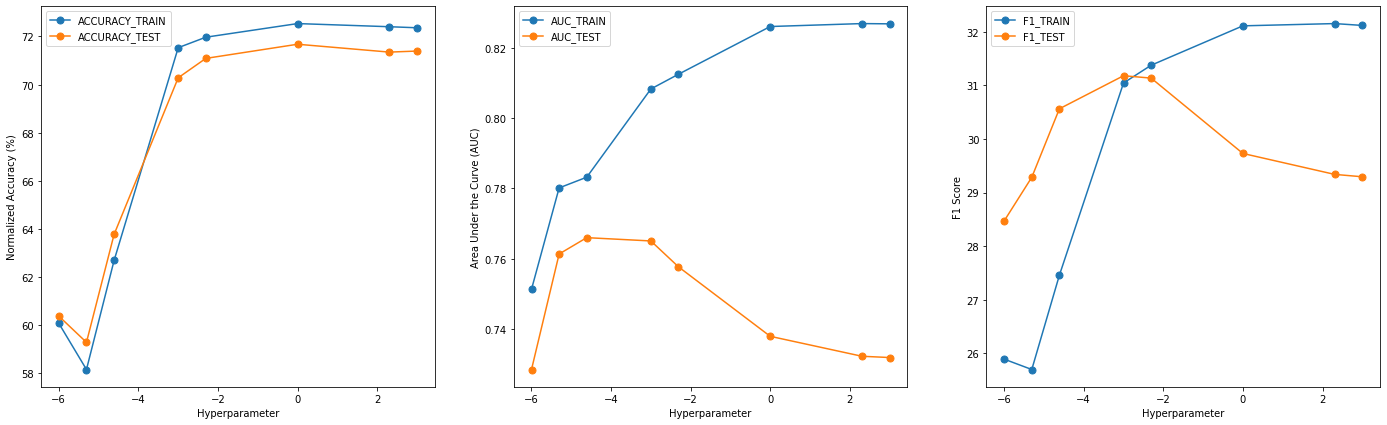

In [ ]:
lr_performance_annual['logc'] = np.log(lr_performance_annual['C'])
plot_train_test_curves(lr_performance_annual,'logc')

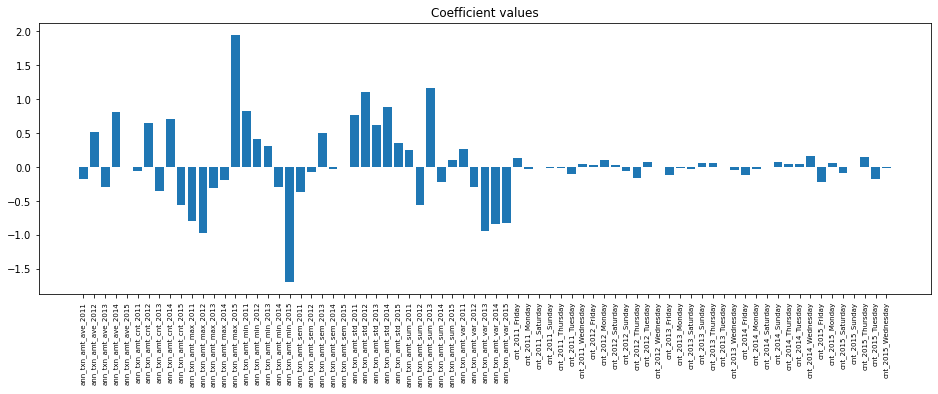

In [ ]:
# 5. Plot coeffcient values or feature importance.
coeffcient = lr.coef_

plt.figure(figsize=(16,5))
plt.bar(range(X_annual.shape[1]), coeffcient[0])
plt.title("Coefficient values")
plt.xticks(range(X_annual.shape[1]), X_annual.columns, rotation=90,size=7)
plt.show()

In [ ]:
y_annual.value_counts()

0    6237
1     647
Name: response, dtype: int64

> 2. Split the data in train and test set. Use a test size value of 2/3 and set the random state
equal to 1147 for consistency (i.e. the course code value). Use the following names for
consistency.

|Annual|Monthly|
| ---------------- | ----------- |
|X_train_annual  y_train_annual| X_train_monthly  y_train_monthly|
|X_test_annual  y_test_annual|X_test_monthly  y_test_monthly|

> 3. Pre-process (if necessary for the method).

> 4. Fit the training dataset and optimize the hyperparameters of the method.

In [ ]:
#drop CLNT_NO, ME_DT and response for X_annual
X_mth = mth_features_outputs.drop(['CLNT_NO', 'response', 'ME_DT'], axis = 1)
y_mth = mth_features_outputs['response']

In [ ]:
X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly = train_test_split(X_mth, y_mth, test_size=2/3, random_state=1147)

> 5. Plot coeffcient values or feature importance.

> 6. Plot probability distribution for test set.

> 7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.

> 8. Plot decision boundary for top 2 features.

### 1.3 Comparison of methods (10 points)

> Compare the two feature engineering (annual and monthly) and the three modeling approaches (L1 log-reg, tree, forests) in terms of the outcomes of steps 5-8. Which combination of feature engineering and modeling approach do you select as the best to deploy in a
production environment and why? Tabularize your findings in steps 5-8 to summarize the
results and support your decision (how to organize information with tables in Markdown).